In [ ]:
!git clone https://github.com/luleu96/GenAIinDD_Exercises.git
%cd /content/GenAIinDD_Exercises

In [ ]:
!pip install rdkit

In [2]:
import pandas as pd
import torch

def char2id(char):
    if char not in c2i:
        return c2i['<unk>']
    else:
        return c2i[char]


def id2char(id):
    if id not in i2c:
        return i2c[32]
    else:
        return i2c[id]

def string2ids(string,add_bos=False, add_eos=False):
    ids = [char2id(c) for c in string]
    if add_bos:
        ids = [c2i['<bos>']] + ids
    if add_eos:
        ids = ids + [c2i['<eos>']]
    return ids
def ids2string(ids, rem_bos=True, rem_eos=True):
    if len(ids) == 0:
        return ''
    if rem_bos and ids[0] == c2i['<bos>']:
        ids = ids[1:]
    if rem_eos and ids[-1] == c2i['<eos>']:
        ids = ids[:-1]
    string = ''.join([id2char(id) for id in ids])
    return string
def string2tensor(string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,device=device if device == 'model' else device)
    return tensor

In [ ]:
import os
working_dir = os.getcwd()

In [3]:
data = pd.read_csv(os.path.join(working_dir, "Data", "vae_data.csv"), sep=';')

data = data.head(3000) # adjust dataset size

train_data1 = data[data['SPLIT'] == 'train']
train_data_smiles2 = (train_data1["SMILES"].squeeze()).astype(str).tolist()
train_data = train_data_smiles2

In [4]:
chars = set()
for string in train_data:
    chars.update(string)
all_sys = sorted(list(chars)) + ['<bos>', '<eos>', '<pad>', '<unk>']
vocab = all_sys
c2i = {c: i for i, c in enumerate(all_sys)}
i2c = {i: c for i, c in enumerate(all_sys)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector = torch.eye(len(c2i))

In [5]:
tensor = [string2tensor(string, device=device) for string in train_data]
vector = torch.eye(len(c2i))

In [12]:
# -*- coding: utf-8 -*-
import torch.nn as nn
import torch.nn.functional as F

q_bidir = True
q_d_h = 256
q_n_layers = 1
q_dropout = 0.5
d_n_layers = 3
d_dropout = 0
d_z = 128
d_d_h = 512

class VAE(nn.Module):
  def __init__(self,vocab,vector):
    super().__init__()
    self.vocabulary = vocab
    self.vector = vector

    n_vocab, d_emb = len(vocab), vector.size(1)
    self.x_emb = nn.Embedding(n_vocab, d_emb, c2i['<pad>'])
    self.x_emb.weight.data.copy_(vector)

    #ENCODER

    self.encoder_rnn = nn.GRU(d_emb,q_d_h,num_layers=q_n_layers,batch_first=True,dropout=q_dropout if q_n_layers > 1 else 0,bidirectional=q_bidir)
    q_d_last = q_d_h * (2 if q_bidir else 1)
    self.q_mu = nn.Linear(q_d_last, d_z)
    self.q_logvar = nn.Linear(q_d_last, d_z)



    # Decoder
    self.decoder_rnn = nn.GRU(d_emb + d_z,d_d_h,num_layers=d_n_layers,batch_first=True,dropout=d_dropout if d_n_layers > 1 else 0)
    self.decoder_latent = nn.Linear(d_z, d_d_h)
    self.decoder_fullyc = nn.Linear(d_d_h, n_vocab)



    # Grouping the model's parameters
    self.encoder = nn.ModuleList([self.encoder_rnn,self.q_mu,self.q_logvar])
    self.decoder = nn.ModuleList([self.decoder_rnn,self.decoder_latent,self.decoder_fullyc])
    self.vae = nn.ModuleList([self.x_emb,self.encoder,self.decoder])



  @property
  def device(self):
    return next(self.parameters()).device

  def string2tensor(self, string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,device=self.device if device == 'model' else device)
    return tensor

  def tensor2string(self, tensor):
    ids = tensor.tolist()
    string = ids2string(ids, rem_bos=True, rem_eos=True)
    return string

  def forward(self,x):
    z, kl_loss = self.forward_encoder(x)
    recon_loss = self.forward_decoder(x, z)
    #print("forward")
    return kl_loss, recon_loss

  def forward_encoder(self,x):
    x = [self.x_emb(i_x) for i_x in x]
    x = nn.utils.rnn.pack_sequence(x)
    _, h = self.encoder_rnn(x, None)
    h = h[-(1 + int(self.encoder_rnn.bidirectional)):]
    h = torch.cat(h.split(1), dim=-1).squeeze(0)
    mu, logvar = self.q_mu(h), self.q_logvar(h)
    eps = torch.randn_like(mu)
    z = mu + (logvar / 2).exp() * eps
    kl_loss = 0.5 * (logvar.exp() + mu ** 2 - 1 - logvar).sum(1).mean()
    return z, kl_loss

  def forward_decoder(self,x, z):
    lengths = [len(i_x) for i_x in x]
    x = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value= c2i['<pad>'])
    x_emb = self.x_emb(x)
    z_0 = z.unsqueeze(1).repeat(1, x_emb.size(1), 1)
    x_input = torch.cat([x_emb, z_0], dim=-1)
    x_input = nn.utils.rnn.pack_padded_sequence(x_input, lengths, batch_first=True)
    h_0 = self.decoder_latent(z)
    h_0 = h_0.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
    output, _ = self.decoder_rnn(x_input, h_0)
    output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
    y = self.decoder_fullyc(output)

    recon_loss = F.cross_entropy(y[:, :-1].contiguous().view(-1, y.size(-1)),x[:, 1:].contiguous().view(-1),ignore_index= c2i['<pad>'])
    return recon_loss


  '''def sample_z_prior(self,n_batch):
    return torch.randn(n_batch,self.q_mu.out_features,device= self.x_emb.weight.device)
  def sample(self,n_batch, max_len=100, z=None, temp=1.0):
    with torch.no_grad():
      if z is None:
        z = self.sample_z_prior(n_batch)
        z = z.to(self.device)
        z_0 = z.unsqueeze(1)
        h = self.decoder_latent(z)
        h = h.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
        w = torch.tensor(c2i['<bos>'], device=self.device).repeat(n_batch)
        x = torch.tensor([c2i['<pad>']], device=device).repeat(n_batch, max_len)
        x[:, 0] = c2i['<bos>']
        end_pads = torch.tensor([max_len], device=self.device).repeat(n_batch)
        eos_mask = torch.zeros(n_batch, dtype=torch.uint8, device=self.device)


        for i in range(1, max_len):
          x_emb = self.x_emb(w).unsqueeze(1)
          x_input = torch.cat([x_emb, z_0], dim=-1)

          o, h = self.decoder_rnn(x_input, h)
          y = self.decoder_fullyc(o.squeeze(1))
          y = F.softmax(y / temp, dim=-1)

          w = torch.multinomial(y, 1)[:, 0]
          x[~eos_mask, i] = w[~eos_mask]
          i_eos_mask = ~eos_mask & ((w == c2i['<eos>'])).bool()#i_eos_mask = ~eos_mask & (w == c2i['<eos>'])
          end_pads[i_eos_mask] = i + 1
          eos_mask = eos_mask | i_eos_mask


          new_x = []
          for i in range(x.size(0)):
            new_x.append(x[i, :end_pads[i]])


    return [self.tensor2string(i_x) for i_x in new_x]'''
  def sample_z_prior(self, n_batch):
    return torch.randn(n_batch, self.q_mu.out_features, device=self.x_emb.weight.device)

  def sample(self, n_batch, max_len=100, z=None, temp=1.0):
      with torch.no_grad():
          if z is None:
              z = self.sample_z_prior(n_batch)
              z = z.to(self.device)
              z_0 = z.unsqueeze(1)
              h = self.decoder_latent(z)
              h = h.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)

          w = torch.tensor(c2i['<bos>'], device=self.device).repeat(n_batch)
          x = torch.tensor([c2i['<pad>']], device=self.device).repeat(n_batch, max_len)
          x[:, 0] = c2i['<bos>']
          end_pads = torch.tensor([max_len], device=self.device).repeat(n_batch)
          # Change dtype to bool explicitly
          eos_mask = torch.zeros(n_batch, dtype=torch.bool, device=self.device)

          for i in range(1, max_len):
              x_emb = self.x_emb(w).unsqueeze(1)
              x_input = torch.cat([x_emb, z_0], dim=-1)

              o, h = self.decoder_rnn(x_input, h)
              y = self.decoder_fullyc(o.squeeze(1))
              y = F.softmax(y / temp, dim=-1)

              w = torch.multinomial(y, 1)[:, 0]
              x[~eos_mask, i] = w[~eos_mask]
              # Ensure boolean mask
              i_eos_mask = ~eos_mask & (w == c2i['<eos>'])
              end_pads[i_eos_mask] = i + 1
              eos_mask = eos_mask | i_eos_mask

          new_x = []
          for i in range(x.size(0)):
              new_x.append(x[i, :end_pads[i]])

          return [self.tensor2string(i_x) for i_x in new_x]

In [17]:
# training

# -*- coding: utf-8 -*-
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import math
import numpy as np
from collections import UserList, defaultdict

n_last = 1000
n_batch = 32
kl_start = 0
kl_w_start = 0.0
kl_w_end = 1.0
n_epoch = 50
n_workers = 0

clip_grad  = 50
lr_start = 0.003
lr_n_period = 10
lr_n_mult = 1
lr_end = 3 * 1e-4
lr_n_restarts = 6


def _n_epoch():
    return sum(lr_n_period * (lr_n_mult ** i) for i in range(lr_n_restarts))

def _train_epoch(model, epoch, train_loader, kl_weight, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    kl_loss_values = CircularBuffer(n_last)
    recon_loss_values = CircularBuffer(n_last)
    loss_values = CircularBuffer(n_last)
    for i, input_batch in enumerate(train_loader):
        input_batch = tuple(data.to(device) for data in input_batch)

    #forward
        kl_loss, recon_loss = model(input_batch)
        loss = kl_weight * kl_loss + recon_loss
    #backward
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(get_optim_params(model),clip_grad)
            optimizer.step()

        kl_loss_values.add(kl_loss.item())
        recon_loss_values.add(recon_loss.item())
        loss_values.add(loss.item())
        lr = (optimizer.param_groups[0]['lr'] if optimizer is not None else None)

    #update train_loader
        kl_loss_value = kl_loss_values.mean()
        recon_loss_value = recon_loss_values.mean()
        loss_value = loss_values.mean()
        postfix = [f'loss={loss_value:.5f}',f'(kl={kl_loss_value:.5f}',f'recon={recon_loss_value:.5f})',f'klw={kl_weight:.5f} lr={lr:.5f}']
    postfix = {'epoch': epoch,'kl_weight': kl_weight,'lr': lr,'kl_loss': kl_loss_value,'recon_loss': recon_loss_value,'loss': loss_value,'mode': 'Eval' if optimizer is None else 'Train'}
    return postfix

def _train(model, train_loader, val_loader=None, logger=None):
    optimizer = optim.Adam(get_optim_params(model),lr= lr_start)

    lr_annealer = CosineAnnealingLRWithRestart(optimizer)

    model.zero_grad()
    for epoch in range(n_epoch):
        print(f'Epoch {epoch}/{n_epoch}')
        kl_annealer = KLAnnealer(n_epoch)
        kl_weight = kl_annealer(epoch)
        postfix = _train_epoch(model, epoch,train_loader, kl_weight, optimizer)
        lr_annealer.step()
def fit(model, train_data, val_data=None):
    logger = Logger() if False is not None else None
    train_loader = get_dataloader(model,train_data,shuffle=True)



    val_loader = None if val_data is None else get_dataloader(model, val_data, shuffle=False)
    _train(model, train_loader, val_loader, logger)
    return model
def get_collate_device(model):
    return model.device
def get_dataloader(model, train_data, collate_fn=None, shuffle=True):
    if collate_fn is None:
        collate_fn = get_collate_fn(model)
        print(collate_fn)
    return DataLoader(train_data, batch_size=n_batch, shuffle=shuffle, num_workers=n_workers, collate_fn=collate_fn)

def get_collate_fn(model):
    device = get_collate_device(model)

    def collate(train_data):
        train_data.sort(key=len, reverse=True)
        tensors = [string2tensor(string, device=device) for string in train_data]
        return tensors

    return collate

def get_optim_params(model):
    return (p for p in model.parameters() if p.requires_grad)

class KLAnnealer:
    def __init__(self,n_epoch):
        self.i_start = kl_start
        self.w_start = kl_w_start
        self.w_max = kl_w_end
        self.n_epoch = n_epoch


        self.inc = (self.w_max - self.w_start) / (self.n_epoch - self.i_start)

    def __call__(self, i):
        k = (i - self.i_start) if i >= self.i_start else 0
        return self.w_start + k * self.inc



class CosineAnnealingLRWithRestart(_LRScheduler):
    def __init__(self , optimizer):
        self.n_period = lr_n_period
        self.n_mult = lr_n_mult
        self.lr_end = lr_end

        self.current_epoch = 0
        self.t_end = self.n_period

        # Also calls first epoch
        super().__init__(optimizer, -1)

    def get_lr(self):
        return [self.lr_end + (base_lr - self.lr_end) *
                (1 + math.cos(math.pi * self.current_epoch / self.t_end)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

        if self.current_epoch == self.t_end:
            self.current_epoch = 0
            self.t_end = self.n_mult * self.t_end




class CircularBuffer:
    def __init__(self, size):
        self.max_size = size
        self.data = np.zeros(self.max_size)
        self.size = 0
        self.pointer = -1

    def add(self, element):
        self.size = min(self.size + 1, self.max_size)
        self.pointer = (self.pointer + 1) % self.max_size
        self.data[self.pointer] = element
        return element

    def last(self):
        assert self.pointer != -1, "Can't get an element from an empty buffer!"
        return self.data[self.pointer]

    def mean(self):
        return self.data.mean()


class Logger(UserList):
    def __init__(self, data=None):
        super().__init__()
        self.sdata = defaultdict(list)
        for step in (data or []):
            self.append(step)

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.data[key]
        elif isinstance(key, slice):
            return Logger(self.data[key])
        else:
            ldata = self.sdata[key]
            if isinstance(ldata[0], dict):
                return Logger(ldata)
            else:
                return ldata

    def append(self, step_dict):
        super().append(step_dict)
        for k, v in step_dict.items():
            self.sdata[k].append(v)





In [18]:
# -*- coding: utf-8 -*-
from tqdm import tqdm
n_samples = 3000
n_jobs = 1
max_len = 100

class sample():
  def take_samples(model,n_batch):
    n = n_samples
    samples = []
    with tqdm(total=n_samples, desc='Generating samples') as T:
      while n > 0:
        current_samples = model.sample(min(n, n_batch), max_len)
        samples.extend(current_samples)
        n -= len(current_samples)
        T.update(len(current_samples))
    samples = pd.DataFrame(samples, columns=['SMILES'])
    return samples

In [19]:
model = VAE(vocab,vector).to(device)
fit(model, train_data)
model.eval()


<function get_collate_fn.<locals>.collate at 0x7d9dec524160>
Epoch 0/50
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50


VAE(
  (x_emb): Embedding(29, 29, padding_idx=27)
  (encoder_rnn): GRU(29, 256, batch_first=True, bidirectional=True)
  (q_mu): Linear(in_features=512, out_features=128, bias=True)
  (q_logvar): Linear(in_features=512, out_features=128, bias=True)
  (decoder_rnn): GRU(157, 512, num_layers=3, batch_first=True)
  (decoder_latent): Linear(in_features=128, out_features=512, bias=True)
  (decoder_fullyc): Linear(in_features=512, out_features=29, bias=True)
  (encoder): ModuleList(
    (0): GRU(29, 256, batch_first=True, bidirectional=True)
    (1-2): 2 x Linear(in_features=512, out_features=128, bias=True)
  )
  (decoder): ModuleList(
    (0): GRU(157, 512, num_layers=3, batch_first=True)
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=29, bias=True)
  )
  (vae): ModuleList(
    (0): Embedding(29, 29, padding_idx=27)
    (1): ModuleList(
      (0): GRU(29, 256, batch_first=True, bidirectional=True)
      (1-2): 2 x Linear(in_featur

In [20]:
sample = sample.take_samples(model,n_batch)
sample

Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 350.48it/s]


,SMILES
0,Cc1cc(C)c(S(=O)(=O)NCC(C)C)c(=O)n1
1,O=C(CSc1nc2ccccc2o1)NC1CCCC1
2,CC1CC(C)Nc2nc(N(C)C)c(C(N)=O)c2C)CC1
3,O=C(Cn1nnc2ccccc2c1=O)Nc1nc2ccccc2s1
4,COc1ccc2oc(=O)c(C(=O)OCC)c2c1
...,...
2995,CCCC(=O)c1nc2cc3c(cc2c3c(N)nc3n1C
2996,N#CCc1ccc(NC(=O)COc2ccc(Cl)cc2B)cc1
2997,CC(=O)Nc1ccc(C(=O)NCc2ccccc2)cc1
2998,COc1ccc(OCC(=O)N2CC(C)C(C)C2)cc1


In [22]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.1/33.1 MB 62.3 MB/s eta 0:00:00


[14:44:59] Can't kekulize mol.  Unkekulized atoms: 1 2 3 5 16
[14:44:59] SMILES Parse Error: extra close parentheses while parsing: CC1CC(C)Nc2nc(N(C)C)c(C(N)=O)c2C)CC1
[14:44:59] SMILES Parse Error: Failed parsing SMILES 'CC1CC(C)Nc2nc(N(C)C)c(C(N)=O)c2C)CC1' for input: 'CC1CC(C)Nc2nc(N(C)C)c(C(N)=O)c2C)CC1'
[14:44:59] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 9 15 16
[14:44:59] SMILES Parse Error: unclosed ring for input: 'COC(=O)c1ccc(NC(=O)COc2ccc3c(c2)oc2C)cc1'
[14:44:59] SMILES Parse Error: unclosed ring for input: 'O=C(CSc1nnc(-c2ccccc2)n1)NCC1=O'
[14:44:59] SMILES Parse Error: unclosed ring for input: 'O=C(CSc1nc2ccccc2[nH]1)COCC1'
[14:44:59] SMILES Parse Error: extra close parentheses while parsing: O=C(C1c2ccccc2Cl)c1ccco1)Nc1ncccn1
[14:44:59] SMILES Parse Error: Failed parsing SMILES 'O=C(C1c2ccccc2Cl)c1ccco1)Nc1ncccn1' for input: 'O=C(C1c2ccccc2Cl)c1ccco1)Nc1ncccn1'


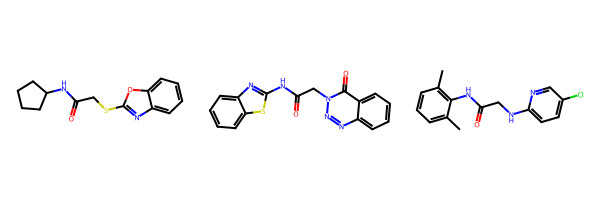

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

def draw_smiles(df, smiles_column, num_molecules=5):
    smiles_list = df[smiles_column].head(num_molecules)
    valid_molecules = []

    for smiles in smiles_list:
        try:
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                valid_molecules.append(mol)
        except:
            print(f"Invalid SMILES: {smiles}")

    if valid_molecules:
        img = Draw.MolsToGridImage(valid_molecules, molsPerRow=3, subImgSize=(200, 200), useSVG=True)
        display(img)
    else:
        print("No valid molecules to display.")

# Sometimes invalid SMILES are produced, these will not be displayed

draw_smiles(sample, 'SMILES', num_molecules=10)